In [1]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt 

import scipy.sparse
from scipy.sparse.linalg import spsolve

from create_mask import Mask 
from overlay_mask import MaskOverlay

In [2]:
src_path = './hieroglyphs.jpg'
target_path = './wall.jpg'

In [56]:
src_image = cv.imread(src_path)
# src_image = src_image[:, :, ::-1]

In [57]:
target_image = cv.imread(target_path)
# target_image = target_image[:, :, ::-1]

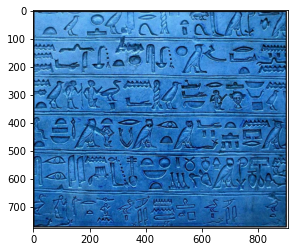

In [58]:
plt.imshow(src_image)
plt.show()

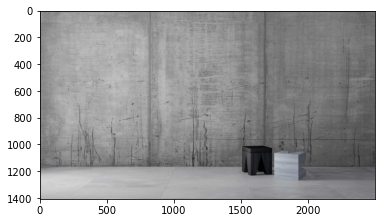

In [59]:
plt.imshow(target_image)
plt.show()

In [7]:
mask = Mask(src_path)
mask_path = mask.select_mask()

In [60]:
mask_path = './mask.jpg'

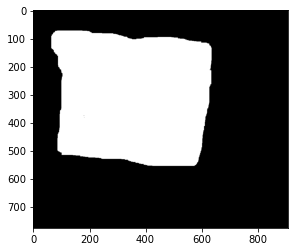

In [61]:
mask_image = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
plt.imshow(mask_image, cmap='gray')
plt.show()

In [9]:
mask_overlay = MaskOverlay(target_path, mask_path)
offset_x, offset_y, target_mask_path = mask_overlay.select_mask()

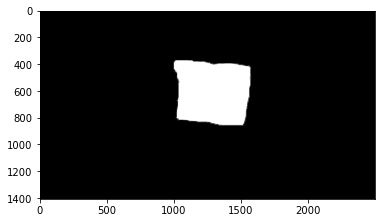

In [62]:
target_mask_image = cv.imread(target_mask_path, cv.IMREAD_GRAYSCALE)
plt.imshow(target_mask_image, cmap='gray')
plt.show()

In [48]:
print(src_image.shape)
print(target_image.shape)
print(mask_image.shape)
print(target_mask_image.shape)

(776, 908, 3)
(1406, 2500, 3)
(776, 908)
(1406, 2500)


In [49]:
def poisson_matrix(n, m):
    
    diag = scipy.sparse.lil_matrix((m, m))
    diag.setdiag(-1, -1)
    diag.setdiag(4)
    diag.setdiag(-1, 1)
    
    A = scipy.sparse.block_diag([diag]*n).tolil()
    
    A.setdiag(-1, 1*m)
    A.setdiag(-1, -1*m)
    
    return A

In [50]:
poisson_matrix(3, 3).todense()

matrix([[ 4., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  4., -1.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  4.,  0.,  0., -1.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  4., -1.,  0., -1.,  0.,  0.],
        [ 0., -1.,  0., -1.,  4., -1.,  0., -1.,  0.],
        [ 0.,  0., -1.,  0., -1.,  4.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  4., -1.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0., -1.,  4., -1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  4.]])

In [79]:
def poisson_blend(src, target, mask, offset):
    
    y_max, x_max = target.shape[:-1]
    y_min, x_min = 0, 0
    
    x_range = x_max - x_min
    y_range = y_max - y_min 
    
    M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
    src = cv.warpAffine(src, M, (x_range, y_range))
    
    plt.imshow(src)
    plt.show()
    
    mask = mask[y_min:y_max, x_min:x_max]
    mask[mask != 0] = 1
    
    plt.imshow(mask, cmap='gray')
    plt.show()

    
    A = poisson_matrix(y_range, x_range)
    
    # for dela g
    laplacian = A.tocsc()
    
    for y in range(1, y_range - 1):
        for x in range(1, x_range - 1):
            if mask[y, x] == 0:
                k = x + y * x_range
                
                A[k, k] = 1
                A[k, k+1] = 0
                A[k, k-1] = 0
                A[k, k+x_range] = 0
                A[k, k-x_range] = 0
                
    
    A = A.tocsc()
    
    flat_mask = mask.flatten()
    
    for channel in range(src.shape[2]):
        
        flat_src = src[y_min:y_max, x_min:x_max, channel].flatten()
        target_flat = target[y_min:y_max, x_min:x_max, channel].flatten()
        
        # delta(f) = div(v) = delta(g)
        alpha = 5.
        B = laplacian.dot(flat_src)*alpha
        
        # outside the mask
        # f = t
        B[flat_mask==0] = target_flat[flat_mask==0]
        
        X = spsolve(A, B)
        X = X.reshape((y_range, x_range))
        
        X[X > 255] = 255
        X[X < 0] = 0
        
        X = X.astype('uint8')
        
        target[y_min:y_max, x_min:x_max, channel] = X
        
        
        return target

(934, 301)


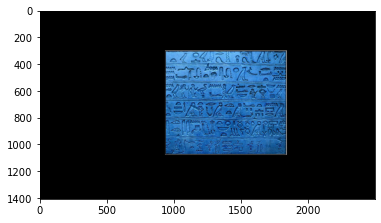

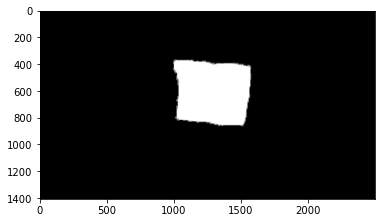

In [80]:
offset = offset_x, offset_y
print(offset)
pb_result = poisson_blend(src_image, target_image, target_mask_image, offset)

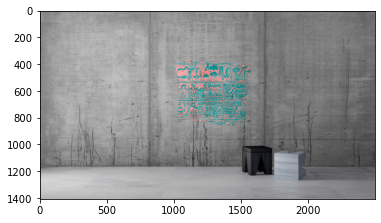

In [81]:
plt.imshow(pb_result)
plt.show()

In [82]:
cv.imwrite('./poisson_edited.jpg', pb_result)

True